# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

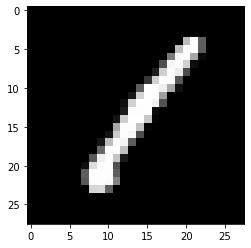

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [5]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_batch256_ensemble" # 設定に変更があった場合ここだけ変更 ensemble
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [8]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 256 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37632/37794 [============================>.] - ETA: 0s - loss: 4.6401 - acc: 0.9508
Epoch 00001: val_loss improved from inf to 4.10037, saving model to img_classifier_model_1_ResNet50_epoch10_batch256_ensemble.h5
37794/37794 [==============================] - 28s 750us/sample - loss: 4.6369 - acc: 0.9510 - val_loss: 4.1004 - val_acc: 0.9239
Epoch 2/10
37632/37794 [============================>.] - ETA: 0s - loss: 3.5019 - acc: 0.9926
Epoch 00002: val_loss improved from 4.10037 to 3.20788, saving model to img_classifier_model_1_ResNet50_epoch10_batch256_ensemble.h5
37794/37794 [==============================] - 16s 427us/sample - loss: 3.5005 - acc: 0.9926 - val_loss: 3.2079 - val_acc: 0.9836
Epoch 3/10
37632/37794 [============================>.] - ETA: 0s - loss: 2.9252 - acc: 0.9989
Epoch 00003: val_loss improved from 3.20788 to 2.75361, saving model to img_classifier_model_1_ResNet50_epoch10_batch256_ensemb

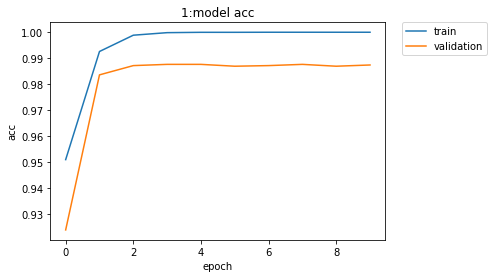

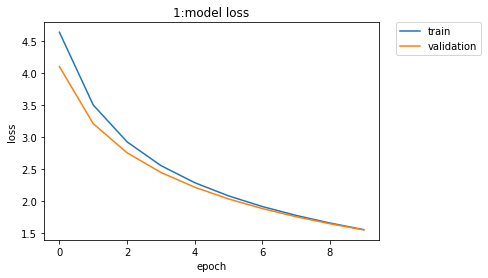

Done compiling best model.


1. Accuracy on validation data: 0.987399
Classification Report
              precision    recall  f1-score   support

           0    0.99281   1.00000   0.99639       414
           1    0.99574   0.99574   0.99574       469
           2    0.98113   0.99522   0.98812       418
           3    0.99072   0.97936   0.98501       436
           4    0.97596   0.99510   0.98544       408
           5    0.98177   0.99211   0.98691       380
           6    0.99756   0.98792   0.99272       414
           7    0.98409   0.98186   0.98297       441
           8    0.98526   0.98526   0.98526       407
           9    0.98775   0.96181   0.97461       419

   micro avg    0.98740   0.98740   0.98740      4206
   macro avg    0.98728   0.98744   0.98732      4206
weighted avg    0.98744   0.98740   0.98738      4206
 samples avg    0.98740   0.98740   0.98740      4206





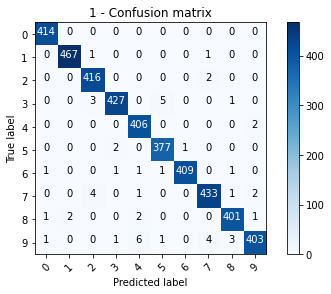

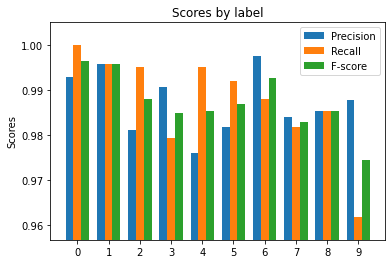

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37632/37796 [============================>.] - ETA: 0s - loss: 4.6497 - acc: 0.9520
Epoch 00001: val_loss improved from inf to 4.07447, saving model to img_classifier_model_2_ResNet50_epoch10_batch256_ensemble.h5
37796/37796 [==============================] - 26s 699us/sample - loss: 4.6464 - acc: 0.9522 - val_loss: 4.0745 - val_acc: 0.9431
Epoch 2/10
37632/37796 [============================>.] - ETA: 0s - loss: 3.5272 - acc: 0.9931- 
Epoch 00002: val_loss improved from 4.07447 to 3.24525, saving model to img_classifier_model_2_ResNet50_epoch10_batch256_ensemble.h5
37796/37796 [==============================] - 16s 430us/sample - loss: 3.5257 - acc: 0.9931 - val_loss: 3.2452 - val_acc: 0.9779
Epoch 3/10
37632/37796 [============================>.] - ETA: 0s - loss: 2.9516 - acc: 0.9988
Epoch 00003: val_loss improved from 3.24525 to 2.78520, saving model to img_classifier_model_2_ResNet50_epoch10_batch256_ense

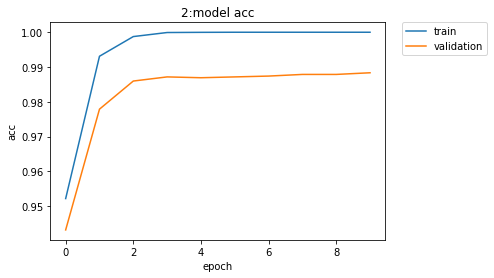

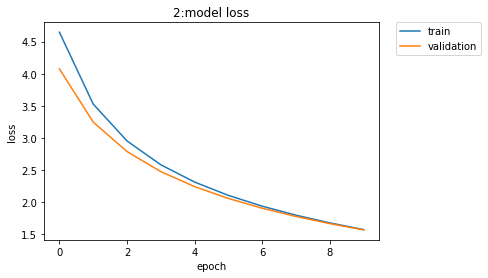

Done compiling best model.


2. Accuracy on validation data: 0.988344
Classification Report
              precision    recall  f1-score   support

           0    0.99516   0.99275   0.99395       414
           1    0.99574   0.99574   0.99574       469
           2    0.98329   0.98565   0.98447       418
           3    0.98843   0.98161   0.98501       435
           4    0.99510   0.99510   0.99510       408
           5    0.98939   0.98158   0.98547       380
           6    0.99272   0.98792   0.99031       414
           7    0.99314   0.98636   0.98974       440
           8    0.97337   0.98771   0.98049       407
           9    0.97642   0.98807   0.98221       419

   micro avg    0.98834   0.98834   0.98834      4204
   macro avg    0.98827   0.98825   0.98825      4204
weighted avg    0.98839   0.98834   0.98835      4204
 samples avg    0.98834   0.98834   0.98834      4204





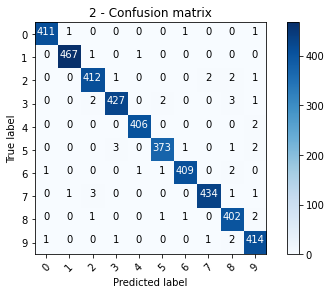

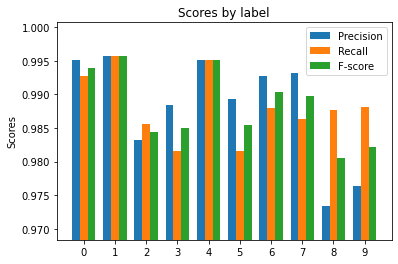

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37632/37798 [============================>.] - ETA: 0s - loss: 4.5983 - acc: 0.9537
Epoch 00001: val_loss improved from inf to 4.10564, saving model to img_classifier_model_3_ResNet50_epoch10_batch256_ensemble.h5
37798/37798 [==============================] - 27s 707us/sample - loss: 4.5957 - acc: 0.9537 - val_loss: 4.1056 - val_acc: 0.9193
Epoch 2/10
37632/37798 [============================>.] - ETA: 0s - loss: 3.4455 - acc: 0.9928
Epoch 00002: val_loss improved from 4.10564 to 3.13213, saving model to img_classifier_model_3_ResNet50_epoch10_batch256_ensemble.h5
37798/37798 [==============================] - 16s 435us/sample - loss: 3.4440 - acc: 0.9928 - val_loss: 3.1321 - val_acc: 0.9862
Epoch 3/10
37632/37798 [============================>.] - ETA: 0s - loss: 2.8661 - acc: 0.9987- ETA: 1s - loss: 2.8843 
Epoch 00003: val_loss improved from 3.13213 to 2.69195, saving model to img_classifier_model_3_ResNet5

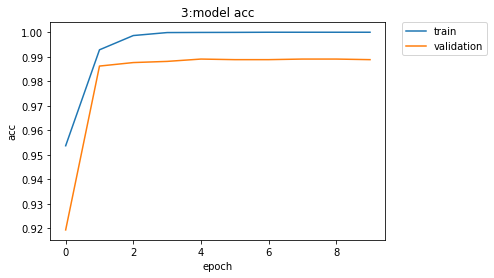

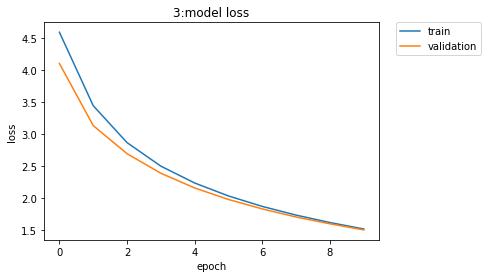

Done compiling best model.


3. Accuracy on validation data: 0.988815
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.98789   0.99391       413
           1    0.99362   0.99574   0.99468       469
           2    0.97867   0.98804   0.98333       418
           3    0.98394   0.98621   0.98507       435
           4    0.98522   0.98280   0.98401       407
           5    0.99735   0.99211   0.99472       380
           6    0.99043   1.00000   0.99519       414
           7    0.99310   0.98182   0.98743       440
           8    0.98533   0.99017   0.98775       407
           9    0.98095   0.98329   0.98212       419

   micro avg    0.98881   0.98881   0.98881      4202
   macro avg    0.98886   0.98881   0.98882      4202
weighted avg    0.98885   0.98881   0.98882      4202
 samples avg    0.98881   0.98881   0.98881      4202





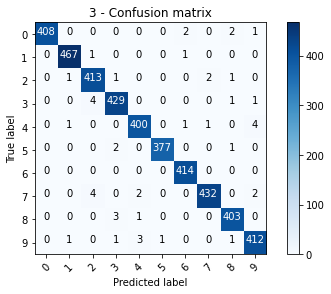

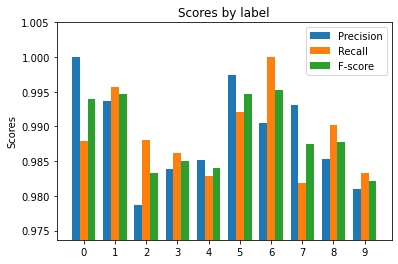

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37632/37799 [============================>.] - ETA: 0s - loss: 4.6250 - acc: 0.9525
Epoch 00001: val_loss improved from inf to 3.99717, saving model to img_classifier_model_4_ResNet50_epoch10_batch256_ensemble.h5
37799/37799 [==============================] - 27s 726us/sample - loss: 4.6218 - acc: 0.9526 - val_loss: 3.9972 - val_acc: 0.9605
Epoch 2/10
37632/37799 [============================>.] - ETA: 0s - loss: 3.4897 - acc: 0.9921
Epoch 00002: val_loss improved from 3.99717 to 3.20652, saving model to img_classifier_model_4_ResNet50_epoch10_batch256_ensemble.h5
37799/37799 [==============================] - 17s 437us/sample - loss: 3.4882 - acc: 0.9921 - val_loss: 3.2065 - val_acc: 0.9788
Epoch 3/10
37632/37799 [============================>.] - ETA: 0s - loss: 2.9133 - acc: 0.9987
Epoch 00003: val_loss improved from 3.20652 to 2.75351, saving model to img_classifier_model_4_ResNet50_epoch10_batch256_ensemb

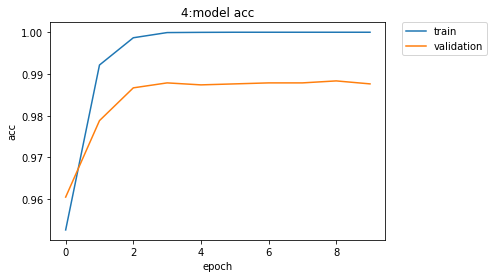

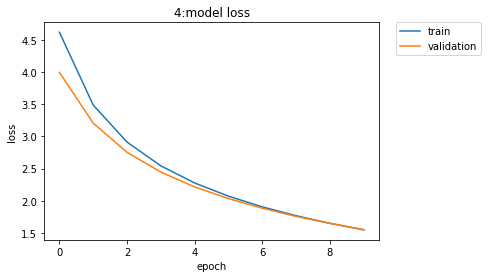

Done compiling best model.


4. Accuracy on validation data: 0.987622
Classification Report
              precision    recall  f1-score   support

           0    0.99272   0.99031   0.99152       413
           1    0.98729   0.99360   0.99044       469
           2    0.99045   0.99282   0.99164       418
           3    0.98618   0.98391   0.98504       435
           4    0.99017   0.99017   0.99017       407
           5    0.98942   0.98421   0.98681       380
           6    0.98558   0.99034   0.98795       414
           7    0.97982   0.99318   0.98646       440
           8    0.98759   0.98030   0.98393       406
           9    0.98792   0.97613   0.98199       419

   micro avg    0.98762   0.98762   0.98762      4201
   macro avg    0.98771   0.98750   0.98759      4201
weighted avg    0.98764   0.98762   0.98762      4201
 samples avg    0.98762   0.98762   0.98762      4201





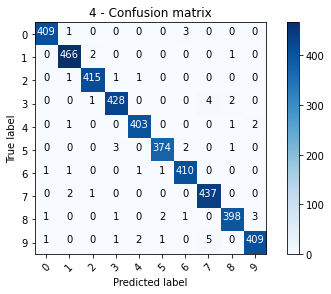

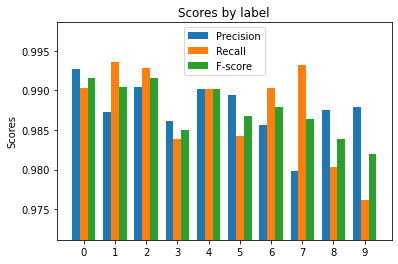

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37632/37800 [============================>.] - ETA: 0s - loss: 4.6193 - acc: 0.9521- ETA: 4s
Epoch 00001: val_loss improved from inf to 4.42498, saving model to img_classifier_model_5_ResNet50_epoch10_batch256_ensemble.h5
37800/37800 [==============================] - 27s 706us/sample - loss: 4.6159 - acc: 0.9523 - val_loss: 4.4250 - val_acc: 0.8540
Epoch 2/10
37632/37800 [============================>.] - ETA: 0s - loss: 3.4739 - acc: 0.9929
Epoch 00002: val_loss improved from 4.42498 to 3.19537, saving model to img_classifier_model_5_ResNet50_epoch10_batch256_ensemble.h5
37800/37800 [==============================] - 16s 436us/sample - loss: 3.4725 - acc: 0.9929 - val_loss: 3.1954 - val_acc: 0.9790
Epoch 3/10
37632/37800 [============================>.] - ETA: 0s - loss: 2.8962 - acc: 0.9980
Epoch 00003: val_loss improved from 3.19537 to 2.74256, saving model to img_classifier_model_5_ResNet50_epoch10_batch2

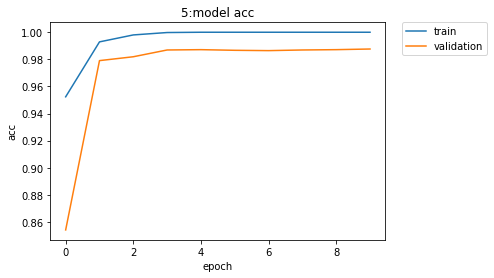

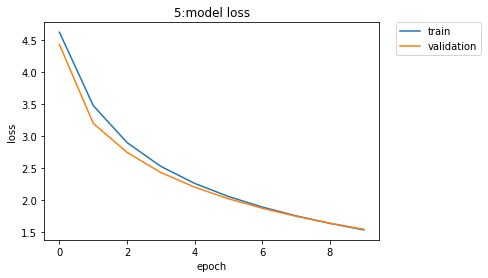

Done compiling best model.


5. Accuracy on validation data: 0.987619
Classification Report
              precision    recall  f1-score   support

           0    0.99757   0.99516   0.99636       413
           1    0.99568   0.98504   0.99033       468
           2    0.98325   0.98325   0.98325       418
           3    0.98845   0.98391   0.98618       435
           4    0.99257   0.98526   0.98890       407
           5    0.98942   0.98421   0.98681       380
           6    0.99275   0.99275   0.99275       414
           7    0.97763   0.99318   0.98534       440
           8    0.97567   0.98768   0.98164       406
           9    0.98333   0.98568   0.98451       419

   micro avg    0.98762   0.98762   0.98762      4200
   macro avg    0.98763   0.98761   0.98761      4200
weighted avg    0.98767   0.98762   0.98763      4200
 samples avg    0.98762   0.98762   0.98762      4200





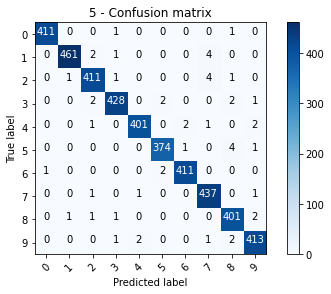

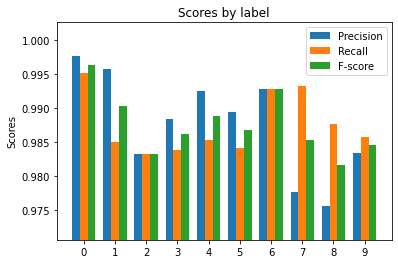

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37632/37801 [============================>.] - ETA: 0s - loss: 4.6005 - acc: 0.9521
Epoch 00001: val_loss improved from inf to 4.01313, saving model to img_classifier_model_6_ResNet50_epoch10_batch256_ensemble.h5
37801/37801 [==============================] - 27s 707us/sample - loss: 4.5972 - acc: 0.9522 - val_loss: 4.0131 - val_acc: 0.9426
Epoch 2/10
37632/37801 [============================>.] - ETA: 0s - loss: 3.4383 - acc: 0.9927
Epoch 00002: val_loss improved from 4.01313 to 3.14807, saving model to img_classifier_model_6_ResNet50_epoch10_batch256_ensemble.h5
37801/37801 [==============================] - 17s 439us/sample - loss: 3.4368 - acc: 0.9927 - val_loss: 3.1481 - val_acc: 0.9802
Epoch 3/10
37632/37801 [============================>.] - ETA: 0s - loss: 2.8580 - acc: 0.9980
Epoch 00003: val_loss improved from 3.14807 to 2.68216, saving model to img_classifier_model_6_ResNet50_epoch10_batch256_ensemb

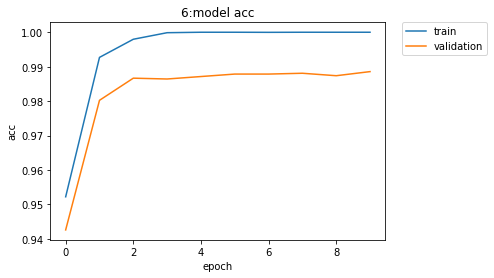

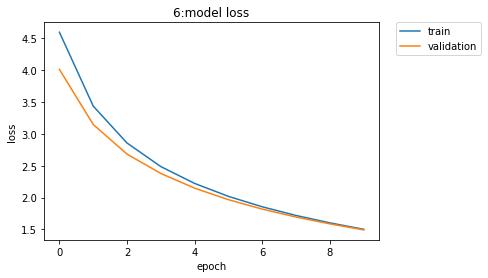

Done compiling best model.


6. Accuracy on validation data: 0.988569
Classification Report
              precision    recall  f1-score   support

           0    0.99029   0.98789   0.98909       413
           1    0.99572   0.99359   0.99465       468
           2    0.98100   0.98804   0.98451       418
           3    0.99304   0.98391   0.98845       435
           4    0.99259   0.98771   0.99015       407
           5    0.99734   0.98945   0.99338       379
           6    0.99041   0.99758   0.99398       414
           7    0.98639   0.98864   0.98751       440
           8    0.96852   0.98522   0.97680       406
           9    0.99038   0.98329   0.98683       419

   micro avg    0.98857   0.98857   0.98857      4199
   macro avg    0.98857   0.98853   0.98854      4199
weighted avg    0.98862   0.98857   0.98858      4199
 samples avg    0.98857   0.98857   0.98857      4199





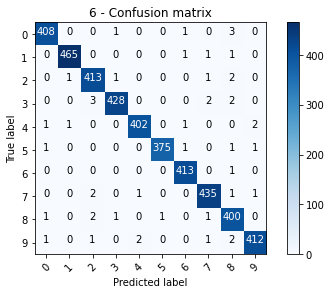

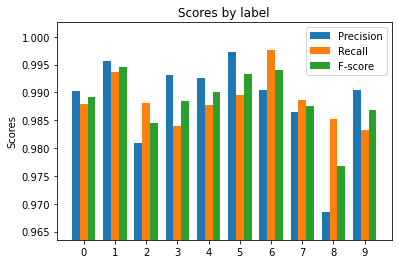

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37632/37801 [============================>.] - ETA: 0s - loss: 4.6307 - acc: 0.9504 - ETA: 9s - loss: 4.8972 - 
Epoch 00001: val_loss improved from inf to 4.31363, saving model to img_classifier_model_7_ResNet50_epoch10_batch256_ensemble.h5
37801/37801 [==============================] - 26s 682us/sample - loss: 4.6275 - acc: 0.9505 - val_loss: 4.3136 - val_acc: 0.8788
Epoch 2/10
37632/37801 [============================>.] - ETA: 0s - loss: 3.4917 - acc: 0.9914
Epoch 00002: val_loss improved from 4.31363 to 3.20018, saving model to img_classifier_model_7_ResNet50_epoch10_batch256_ensemble.h5
37801/37801 [==============================] - 17s 438us/sample - loss: 3.4902 - acc: 0.9914 - val_loss: 3.2002 - val_acc: 0.9819
Epoch 3/10
37632/37801 [============================>.] - ETA: 0s - loss: 2.9142 - acc: 0.9987
Epoch 00003: val_loss improved from 3.20018 to 2.74761, saving model to img_classifier_model_7_ResN

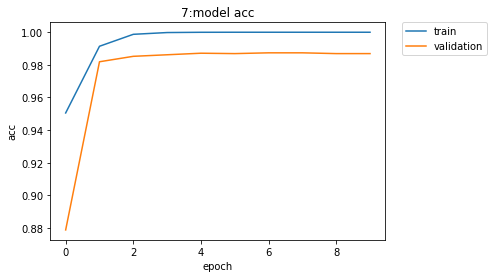

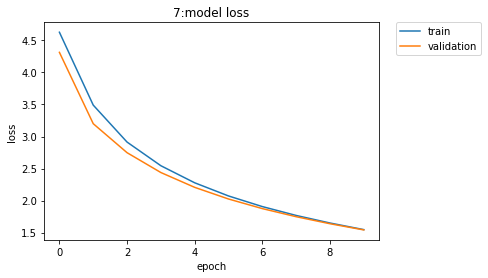

Done compiling best model.


7. Accuracy on validation data: 0.986902
Classification Report
              precision    recall  f1-score   support

           0    0.98795   0.99274   0.99034       413
           1    0.98938   0.99573   0.99255       468
           2    0.98077   0.97608   0.97842       418
           3    0.99074   0.98391   0.98731       435
           4    0.98533   0.99017   0.98775       407
           5    0.98677   0.98417   0.98547       379
           6    0.98313   0.98551   0.98432       414
           7    0.98198   0.99091   0.98643       440
           8    0.99015   0.99015   0.99015       406
           9    0.99274   0.97852   0.98558       419

   micro avg    0.98690   0.98690   0.98690      4199
   macro avg    0.98689   0.98679   0.98683      4199
weighted avg    0.98691   0.98690   0.98690      4199
 samples avg    0.98690   0.98690   0.98690      4199





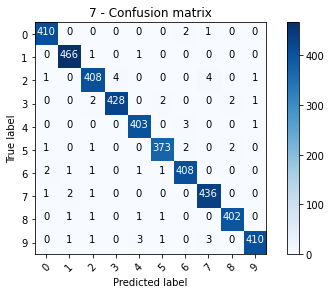

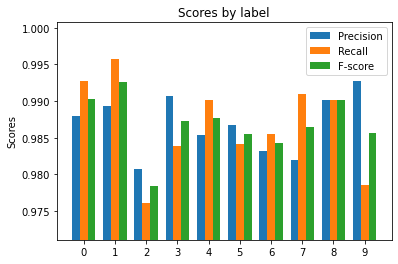

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37632/37803 [============================>.] - ETA: 0s - loss: 4.6446 - acc: 0.9511
Epoch 00001: val_loss improved from inf to 4.03174, saving model to img_classifier_model_8_ResNet50_epoch10_batch256_ensemble.h5
37803/37803 [==============================] - 27s 706us/sample - loss: 4.6412 - acc: 0.9513 - val_loss: 4.0317 - val_acc: 0.9552
Epoch 2/10
37632/37803 [============================>.] - ETA: 0s - loss: 3.5265 - acc: 0.9917
Epoch 00002: val_loss improved from 4.03174 to 3.22198, saving model to img_classifier_model_8_ResNet50_epoch10_batch256_ensemble.h5
37803/37803 [==============================] - 17s 440us/sample - loss: 3.5251 - acc: 0.9917 - val_loss: 3.2220 - val_acc: 0.9862
Epoch 3/10
37632/37803 [============================>.] - ETA: 0s - loss: 2.9517 - acc: 0.9990
Epoch 00003: val_loss improved from 3.22198 to 2.78008, saving model to img_classifier_model_8_ResNet50_epoch10_batch256_ensemb

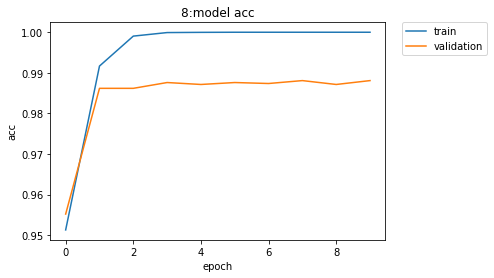

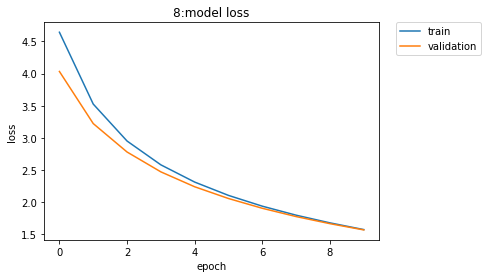

Done compiling best model.


8. Accuracy on validation data: 0.988087
Classification Report
              precision    recall  f1-score   support

           0    0.98321   0.99274   0.98795       413
           1    0.99362   0.99786   0.99574       468
           2    0.99275   0.98561   0.98917       417
           3    0.99535   0.98391   0.98960       435
           4    0.98305   0.99754   0.99024       407
           5    0.98417   0.98417   0.98417       379
           6    0.98792   0.99031   0.98912       413
           7    0.98864   0.98864   0.98864       440
           8    0.98280   0.98522   0.98401       406
           9    0.98789   0.97375   0.98077       419

   micro avg    0.98809   0.98809   0.98809      4197
   macro avg    0.98794   0.98798   0.98794      4197
weighted avg    0.98811   0.98809   0.98808      4197
 samples avg    0.98809   0.98809   0.98809      4197





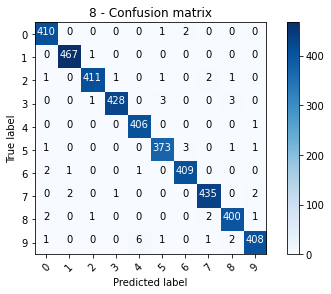

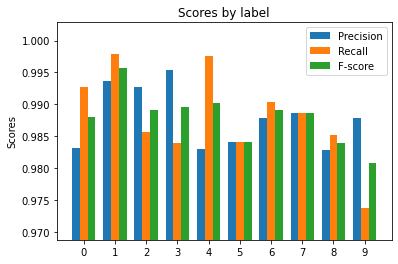

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37632/37804 [============================>.] - ETA: 0s - loss: 4.6110 - acc: 0.9536- ETA: 4s - l
Epoch 00001: val_loss improved from inf to 3.95490, saving model to img_classifier_model_9_ResNet50_epoch10_batch256_ensemble.h5
37804/37804 [==============================] - 27s 714us/sample - loss: 4.6078 - acc: 0.9537 - val_loss: 3.9549 - val_acc: 0.9566
Epoch 2/10
37632/37804 [============================>.] - ETA: 0s - loss: 3.4634 - acc: 0.9918  E -  - ETA: 3
Epoch 00002: val_loss improved from 3.95490 to 3.16650, saving model to img_classifier_model_9_ResNet50_epoch10_batch256_ensemble.h5
37804/37804 [==============================] - 17s 440us/sample - loss: 3.4619 - acc: 0.9918 - val_loss: 3.1665 - val_acc: 0.9814
Epoch 3/10
37632/37804 [============================>.] - ETA: 0s - loss: 2.8846 - acc: 0.9982- ETA: 3s
Epoch 00003: val_loss improved from 3.16650 to 2.70869, saving model to img_classifier_mod

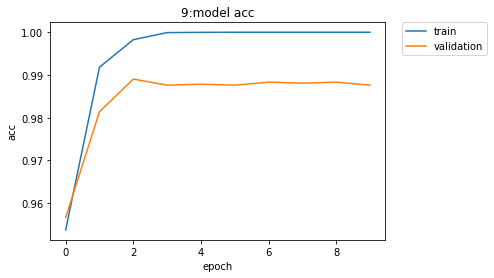

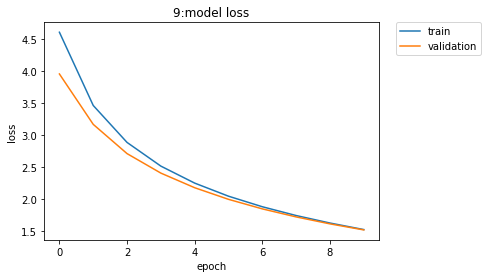

Done compiling best model.


9. Accuracy on validation data: 0.987607
Classification Report
              precision    recall  f1-score   support

           0    0.98333   1.00000   0.99160       413
           1    0.98726   0.99359   0.99042       468
           2    0.98786   0.97602   0.98191       417
           3    1.00000   0.98851   0.99422       435
           4    0.99012   0.98526   0.98768       407
           5    0.99211   0.99472   0.99341       379
           6    0.99274   0.99274   0.99274       413
           7    0.98194   0.98864   0.98528       440
           8    0.97101   0.99015   0.98049       406
           9    0.99020   0.96651   0.97821       418

   micro avg    0.98761   0.98761   0.98761      4196
   macro avg    0.98766   0.98761   0.98759      4196
weighted avg    0.98767   0.98761   0.98760      4196
 samples avg    0.98761   0.98761   0.98761      4196





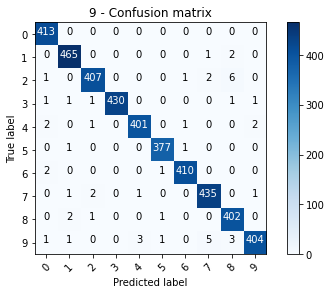

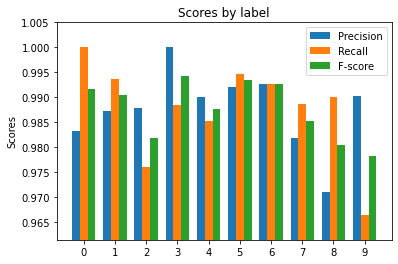

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37632/37804 [============================>.] - ETA: 0s - loss: 4.6517 - acc: 0.9509- ETA: 1s - loss: 4.6852 - acc:
Epoch 00001: val_loss improved from inf to 4.13088, saving model to img_classifier_model_10_ResNet50_epoch10_batch256_ensemble.h5
37804/37804 [==============================] - 25s 666us/sample - loss: 4.6486 - acc: 0.9510 - val_loss: 4.1309 - val_acc: 0.9321
Epoch 2/10
37632/37804 [============================>.] - ETA: 0s - loss: 3.5274 - acc: 0.9930
Epoch 00002: val_loss improved from 4.13088 to 3.23313, saving model to img_classifier_model_10_ResNet50_epoch10_batch256_ensemble.h5
37804/37804 [==============================] - 17s 442us/sample - loss: 3.5260 - acc: 0.9929 - val_loss: 3.2331 - val_acc: 0.9831
Epoch 3/10
37632/37804 [============================>.] - ETA: 0s - loss: 2.9533 - acc: 0.9989
Epoch 00003: val_loss improved from 3.23313 to 2.79071, saving model to img_classifier_model_

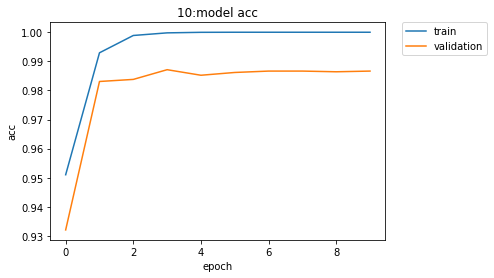

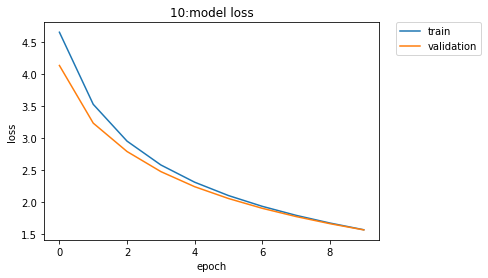

Done compiling best model.


10. Accuracy on validation data: 0.986654
Classification Report
              precision    recall  f1-score   support

           0    0.99270   0.98789   0.99029       413
           1    0.99145   0.99145   0.99145       468
           2    0.98810   0.99520   0.99164       417
           3    0.98840   0.97931   0.98383       435
           4    0.98044   0.98526   0.98284       407
           5    0.98947   0.99208   0.99078       379
           6    0.98551   0.98789   0.98670       413
           7    0.98405   0.98182   0.98294       440
           8    0.98522   0.98522   0.98522       406
           9    0.98086   0.98086   0.98086       418

   micro avg    0.98665   0.98665   0.98665      4196
   macro avg    0.98662   0.98670   0.98666      4196
weighted avg    0.98666   0.98665   0.98665      4196
 samples avg    0.98665   0.98665   0.98665      4196





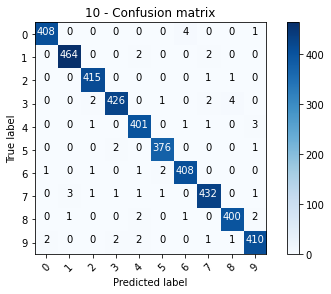

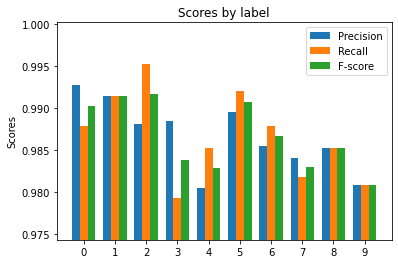

In [9]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
if "ensemble" in model_name:
    for i in glob.glob("*model*"+model_name+"*"+"h5"):
        shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.987762
Classification Report
              precision    recall  f1-score   support

           0    0.99154   0.99274   0.99214      4132
           1    0.99254   0.99381   0.99317      4684
           2    0.98471   0.98659   0.98565      4177
           3    0.99051   0.98345   0.98697      4351
           4    0.98702   0.98944   0.98823      4072
           5    0.98970   0.98788   0.98879      3795
           6    0.98986   0.99130   0.99058      4137
           7    0.98504   0.98750   0.98627      4401
           8    0.98044   0.98671   0.98356      4063
           9    0.98580   0.97779   0.98178      4188

   micro avg    0.98776   0.98776   0.98776     42000
   macro avg    0.98771   0.98772   0.98771     42000
weighted avg    0.98777   0.98776   0.98776     42000
 samples avg    0.98776   0.98776   0.98776     42000





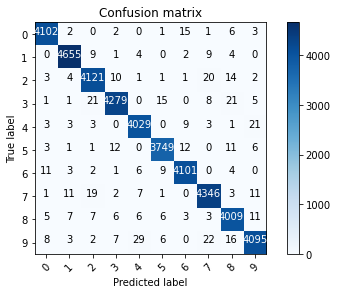

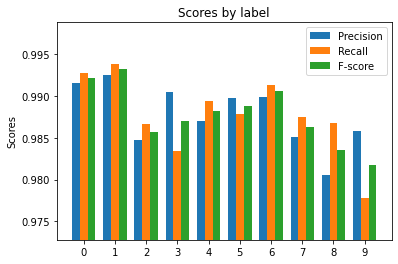

In [10]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

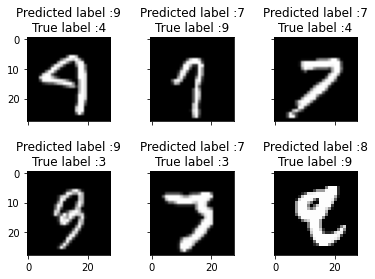

In [11]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 25s 588us/sample - loss: 4.5243 - acc: 0.9563
Epoch 2/10
42000/42000 [==============================] - 17s 401us/sample - loss: 3.3556 - acc: 0.9912
Epoch 3/10
42000/42000 [==============================] - 17s 400us/sample - loss: 2.7826 - acc: 0.9982
Epoch 4/10
42000/42000 [==============================] - 17s 409us/sample - loss: 2.4237 - acc: 0.9996
Epoch 5/10
42000/42000 [==============================] - 18s 429us/sample - loss: 2.1665 - acc: 1.0000
Epoch 6/10
42000/42000 [==============================] - 18s 419us/sample - loss: 1.9686 - acc: 1.0000
Epoch 7/10
42000/42000 [==============================] - 18s 423us/sample - loss: 1.8087 - acc: 1.0000
Epoch 8/10
42000/42000 [==============================] - 18s 423us/sample - loss: 1.6844 - acc: 0.9992
Epoch 9/10
42000/42000 [==============================] - 18s 429us/sample - loss: 1.5771 - acc: 1.0000
Epoch 10/10
42000/42000 [================

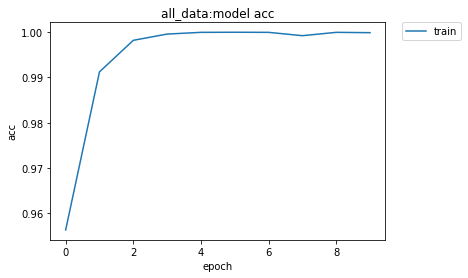

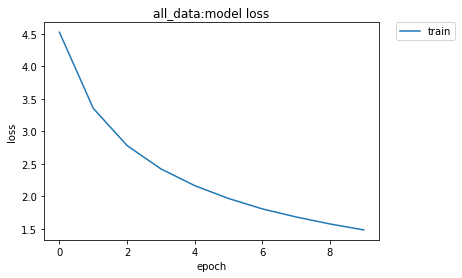

In [13]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [14]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

514797

# 6. Ensemble model test

In [15]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)